# `rayoptics` model of the prototype

In [1]:
from rayoptics.environment import *
import matplotlib.pyplot as plt
import numpy as np

# Create lens models

We start by defining some optical systems.
For later convenience, we define each through a function.
Each assumes a fixed distance between the image plane and eyepiece lens, and a fixed distance between the eyepiece and objective lenses.

In [2]:
image_distance = 50.0
eyepiece_objective_separation = 100.0
green = [(528, 1.0)]
red = [(650, 1.0)]
green_red = [(528, 1.0), (650, 1.0)]
on_axis = [0.]
off_axis = [0.5]
on_off_axis = [0.0, 0.5]

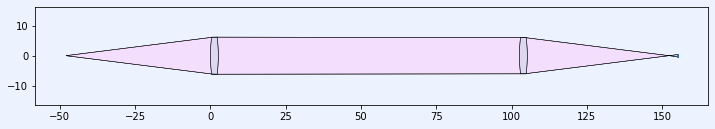

In [3]:
def biconvex_prototype(object_plane_distance, object_field_radial, wavelengths):
    opm = OpticalModel()
    sm  = opm.seq_model
    osp = opm.optical_spec
    pm = opm.parax_model

    osp.pupil = PupilSpec(osp, key=['object', 'pupil'], value=12.5)
    osp.field_of_view = FieldSpec(osp, key=['object', 'height'], flds=object_field_radial)
    osp.spectral_region = WvlSpec(wavelengths, ref_wl=0)
    opm.radius_mode = True
    lens_thickness = 2.6
    lens_R = 51.1

    sm.gaps[0].thi=object_plane_distance
    sm.add_surface([lens_R, lens_thickness, 'N-BK7', 'Schott'])
    sm.add_surface([-lens_R, eyepiece_objective_separation])
    sm.set_stop()
    sm.add_surface([lens_R, lens_thickness, 'N-BK7', 'Schott'])
    sm.add_surface([-lens_R, image_distance])
    opm.update_model()
    return opm

model = biconvex_prototype(48.0, on_axis, green);
layout_plt = plt.figure(FigureClass=LensLayoutFigure, opt_model=model, do_draw_rays=True, offset_factor=100.0, do_draw_frame=True).plot()
layout_plt.set_size_inches(10,2)

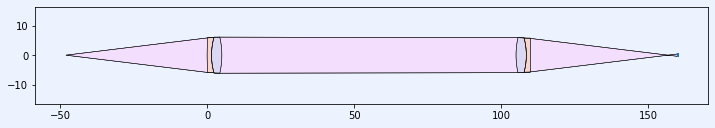

In [4]:
# Doublet setup uses Thorlabs AC127-050-A
def doublet_prototype(object_plane_distance, object_field_radial, wavelengths):
    opm = OpticalModel()
    sm  = opm.seq_model
    osp = opm.optical_spec
    pm = opm.parax_model

    osp.pupil = PupilSpec(osp, key=['object', 'pupil'], value=12.5)
    osp.field_of_view = FieldSpec(osp, key=['object', 'height'], flds=object_field_radial)
    osp.spectral_region = WvlSpec(wavelengths, ref_wl=0)
    opm.radius_mode = True
    
    sm.gaps[0].thi= object_plane_distance
    sm.add_surface([91.8, 1.5, 'SF2', 'Schott'])
    sm.add_surface([22.5, 3.5, 'N-BK7', 'Schott'])
    sm.add_surface([-27.4, eyepiece_objective_separation])    
    sm.set_stop()
    sm.add_surface([27.4, 3.5, 'N-BK7', 'Schott'])
    sm.add_surface([-22.5, 1.5, 'SF2', 'Schott'])
    sm.add_surface([-91.8, image_distance])
    
    #sm.add_surface([27.4, 3.5, 'N-BK7', 'Schott'])
    #sm.add_surface([-22.5, 1.5, 'SF2', 'Schott'])
    #sm.add_surface([-91.8, eyepiece_objective_separation])
    #sm.set_stop()
    #sm.add_surface([91.8, 1.5, 'SF2', 'Schott'])
    #sm.add_surface([22.5, 3.5, 'N-BK7', 'Schott'])
    #sm.add_surface([-27.4, image_distance])
    opm.update_model()
    return opm

model = doublet_prototype(48.0, on_axis, green);
layout_plt = plt.figure(FigureClass=LensLayoutFigure, opt_model=model, do_draw_rays=True, offset_factor=100.0, do_draw_frame=True).plot()
layout_plt.set_size_inches(10,2)

Find the working distances for each setup, by minimising the circle of least confusion.

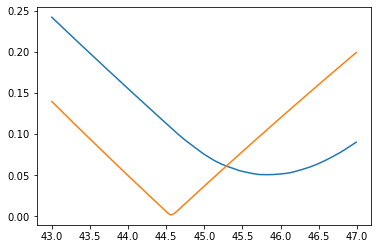

wd_biconvex=45.82
wd_doublet=44.56


In [5]:
def get_spot_size(opt_model):
    seq_model = opt_model.seq_model
    osp = opt_model.optical_spec
    # get 0th field and wavelength.
    fld, wvl, foc = osp.lookup_fld_wvl_focus(0, wl=0)
    
    def spot(p, wi, ray_pkg, fld, wvl, foc):
        if ray_pkg is not None:
            image_pt = fld.ref_sphere[0]
            ray = ray_pkg[mc.ray]
            dist = foc / ray[-1][mc.d][2]
            defocused_pt = ray[-1][mc.p] - dist*ray[-1][mc.d]
            t_abr = defocused_pt - image_pt
            return np.array([t_abr[0], t_abr[1]])
        else:
            return None
    
    (points, _) = seq_model.trace_grid(spot, 0, num_rays=21, form='list', append_if_none=False)
    x = np.transpose(points)[0]
    y = np.transpose(points)[1]
    #plt.scatter(x,y)
    r = np.power(np.power(x,2) + np.power(y,2), 0.5)
    return np.mean(r)

def get_biconvex_spot_size(image_distance):
    model = biconvex_prototype(image_distance, on_axis, green)
    return get_spot_size(model)

def get_doublet_spot_size(image_distance):
    model = doublet_prototype(image_distance, on_axis, green)
    return get_spot_size(model)

distances = np.arange(43.0, 47.0, 0.03)
radii = [get_biconvex_spot_size(d) for d in distances]
plt.plot(distances, radii)
wd_biconvex = distances[np.argmin(radii)]

radii = [get_doublet_spot_size(d) for d in distances]
plt.plot(distances, radii)
wd_doublet = distances[np.argmin(radii)]

plt.show()
print("wd_biconvex={:.2f}".format(wd_biconvex))
print("wd_doublet={:.2f}".format(wd_doublet))

# Spot Diagrams


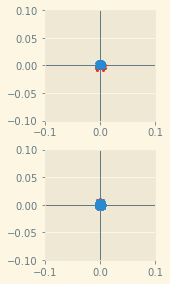

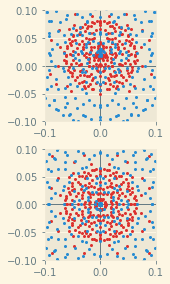

In [6]:
def set_limits(fig):
    for ax in fig.get_axes():
        ax.set_ylim(-0.1,0.1)
        ax.set_xlim(-0.1,0.1)
    return fig

model = doublet_prototype(wd_doublet, on_off_axis, green_red)
p = set_limits(plt.figure(FigureClass=SpotDiagramFigure, opt_model=model).plot())

model = biconvex_prototype(wd_biconvex, on_off_axis, green_red)
p = set_limits(plt.figure(FigureClass=SpotDiagramFigure, opt_model=model).plot())

It is clear that, when focussed, the doublet system significantly outperforms the biconvex system, with respect to:
* chromatic abberations
* spherical abberations
* comar/astigmatism


# Plot the wavefront abberation

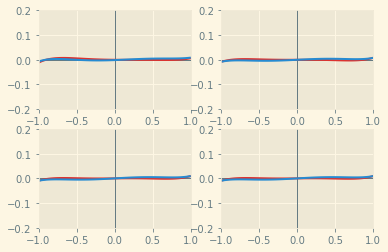

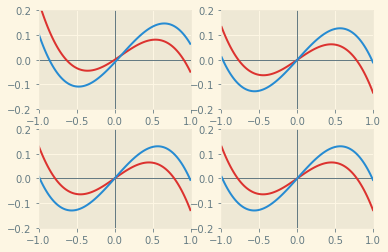

In [7]:
#model = singlet_lens_system(f_singlet, f_singlet, 100.0);
#p_singlet = plt.figure(FigureClass=RayFanFigure, opt_model=model, data_type='OPD', scale_type=Fit.All_Same).plot()

#model = biconvex_lens_system(f_biconvex, f_biconvex, 100.0);
#p_biconvex = plt.figure(FigureClass=RayFanFigure, opt_model=model, data_type='OPD').plot()

#model = doublet_lens_system_swap(f_doublet_swap, f_doublet_swap, 100.0);
#p_doublet = plt.figure(FigureClass=RayFanFigure, opt_model=model, data_type='OPD').plot()

def set_limits(fig):
    for ax in fig.get_axes():
        ax.set_ylim(-0.2,0.2)
        ax.set_xlim(-1,1)
    return fig

model = doublet_prototype(wd_doublet, on_off_axis, green_red)
p = set_limits(plt.figure(FigureClass=RayFanFigure, opt_model=model, data_type='Ray').plot())

model = biconvex_prototype(wd_biconvex, on_off_axis, green_red)
p = set_limits(plt.figure(FigureClass=RayFanFigure, opt_model=model, data_type='Ray').plot())